## HW6 

In [2]:
from importlib.metadata import version

pkgs = ["matplotlib",  # Plotting library
        "numpy",       # PyTorch & TensorFlow dependency
        "tiktoken",    # Tokenizer
        "torch",       # Deep learning library
        "tensorflow",  # For OpenAI's pretrained weights
        "pandas"       # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.4
numpy version: 1.26.4
tiktoken version: 0.5.1
torch version: 2.7.1+cu118
tensorflow version: 2.15.0
pandas version: 2.3.1


Download Dataset

In [3]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path) 

File downloaded and saved as sms_spam_collection\SMSSpamCollection.tsv


Check Dataset inner content

In [93]:
import pandas as pd
df = pd.read_csv("sms_spam_collection\SMSSpamCollection.tsv", sep = "\t", header=None, names=["Label", "Text"])
print(df)
print(df['Label'].value_counts())
num_spam = df[df['Label']=='spam'].shape
print(num_spam)

     Label                                               Text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]
Label
ham     4825
spam     747
Name: count, dtype: int64
(747, 2)


Balance Dataset Label

In [94]:
def create_balance_dataset(raw_data):
    num_spam = raw_data[raw_data['Label']=='spam'].shape[0]  # spam的數量 >> .shape()= [count, value]
    ham_subset = raw_data[raw_data['Label']=='ham'].sample(num_spam, random_state=123) # 隨機選擇ham 數量跟spam一樣
    balance_raw_data = pd.concat([ham_subset, raw_data[raw_data['Label']=="spam"]]) #合併spam, ham的data set
    return balance_raw_data

balance_data = create_balance_dataset(df)
balance_data["Label"] = balance_data['Label'].map({'ham':0, 'spam': 1}) # 修改balance_data中["Label"] 的值, 'ham':0, 'spam': 1
print(balance_data)
print(balance_data['Label'].value_counts()) #統計各label的數量

      Label                                               Text
4307      0  Awww dat is sweet! We can think of something t...
4138      0                             Just got to  &lt;#&gt;
4831      0  The word "Checkmate" in chess comes from the P...
4461      0  This is wishing you a great day. Moji told me ...
5440      0      Thank you. do you generally date the brothas?
...     ...                                                ...
5537      1  Want explicit SEX in 30 secs? Ring 02073162414...
5540      1  ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547      1  Had your contract mobile 11 Mnths? Latest Moto...
5566      1  REMINDER FROM O2: To get 2.50 pounds free call...
5567      1  This is the 2nd time we have tried 2 contact u...

[1494 rows x 2 columns]
Label
0    747
1    747
Name: count, dtype: int64


Split dataset

In [95]:
def data_split(dataset, train_data_pg, vail_data_pg):
    total_dataset_cont = len(dataset)
    random_dataset = dataset.sample(frac=1, random_state=123).reset_index(drop=True) #frac=1 指資料100%保留
    train_data_len = int(total_dataset_cont*train_data_pg)
    vail_data_len = int(total_dataset_cont*(train_data_pg+vail_data_pg))
    train_data = random_dataset[:train_data_len]
    vail_data = random_dataset[train_data_len:vail_data_len]
    test_data = random_dataset[vail_data_len:]

    return train_data, vail_data, test_data

# dataset = balance_data
train_data_pg = 0.7
vail_data_pg = 0.1
train_data, vail_data, test_data = data_split(balance_data, train_data_pg, vail_data_pg)
total = train_data.shape[0]+ vail_data.shape[0]+ test_data.shape[0] 
print(train_data.shape[0]/total, vail_data.shape[0]/total, test_data.shape[0]/total )

train_data.to_csv("train_data.csv", index=None)
vail_data.to_csv("vail_data.csv", index=None)
test_data.to_csv("test_data.csv", index=None)

0.6994645247657296 0.10040160642570281 0.2001338688085676


### Create Dataset Loader  
有兩個方法:  
1. 截短  
2. 補長  
以|endoftext|作為補長的字元  

In [78]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')
print(tokenizer.encode("<|endoftext|>",allowed_special={"<|endoftext|>"}))

[50256]


In [112]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length = None, pad_token_id = 50256):
        self.data = pd.read_csv(csv_file)

        self.encoded_texts = [ 
            tokenizer.encode(text) for text in self.data['Text']  # 先對Dataset做tokenID的轉換(斷詞)
            ] 
        
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # print(max_length)
            self.encoded_texts = [
                encoded_text[:self.max_length] 
                for encoded_text in self.encoded_texts] # 截斷超過最大設定長度的文本

        self.encoded_texts = [ 
            encoded_text + [pad_token_id]*(self.max_length-len(encoded_text)) 
            for encoded_text in self.encoded_texts] # 填充pad_token_id讓encoded_texts到設定的長度max_length

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (torch.tensor(encoded, dtype = torch.long), 
                torch.tensor(label, dtype = torch.long))

    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


In [117]:
tokenizer = tiktoken.get_encoding('gpt2')
# csv_file = "train_data.csv"



train_dataset = SpamDataset(
    csv_file = "train_data.csv",
    max_length = None,
    tokenizer = tokenizer
)

print(train_dataset.max_length)
for x, y in train_dataset:
    print(x, y)

120
tensor([   35,  2507,   703,   466,   345,   588,   262,  6940,  2344,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]) tensor(0)
tensor([   51,   408,    88,   492,   489,    82,

In [118]:
vail_dataset = SpamDataset(
    csv_file = "vail_data.csv",
    max_length = train_dataset.max_length,
    tokenizer = tokenizer
)
test_dataset = SpamDataset(
    csv_file = "test_data.csv",
    max_length = train_dataset.max_length,
    tokenizer = tokenizer
)

HW6.1  
ANS: 會讓Input有太多無意義資料，反而影響輸出結果

Dataloader

In [147]:
import gpt
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)
train_loader = DataLoader(
    dataset= train_dataset,
    batch_size= batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)
val_loader = DataLoader(
    dataset= vail_dataset,
    batch_size= batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)
test_loader = DataLoader(
    dataset= test_dataset,
    batch_size= batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

In [148]:
for x, y in train_loader:
    pass
print(x.shape, y.shape)
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

torch.Size([8, 120]) torch.Size([8])
130
18
37


## Load preTrain Model weight

In [135]:
import os
import urllib.request

# import requests
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate_emb": 0.1,
    "drop_rate_ShortCut": 0.1,
    "drop_rate_mha": 0.1,
    "qkv_bias": False
}


def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

def load_gpt2(models_dir):

    # Define paths
    model_dir = os.path.join(models_dir)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json"), "r", encoding="utf-8"))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params

models_dir = "C:\\Users\\user\\Desktop\\LLM\\LLM_Implementation\\gpt2\\124M"
load_settings, load_params = load_gpt2(models_dir)

import gpt

# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt_openAI_model = gpt.GPTModel(NEW_CONFIG)
import numpy as np
import torch 

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.w_query.weight = assign(gpt.trf_blocks[b].att.w_query.weight, q_w.T)
        gpt.trf_blocks[b].att.w_key.weight = assign(gpt.trf_blocks[b].att.w_key.weight, k_w.T)
        gpt.trf_blocks[b].att.w_value.weight = assign(gpt.trf_blocks[b].att.w_value.weight, v_w.T)

        q_b, k_b, v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.w_query.bias = assign(gpt.trf_blocks[b].att.w_query.bias, q_b)
        gpt.trf_blocks[b].att.w_key.bias = assign(gpt.trf_blocks[b].att.w_key.bias, k_b)
        gpt.trf_blocks[b].att.w_value.bias = assign(gpt.trf_blocks[b].att.w_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(gpt.trf_blocks[b].att.out_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(gpt.trf_blocks[b].att.out_proj.bias, params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(gpt.trf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(gpt.trf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(gpt.trf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm2.scale, params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm2.shift, params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt_openAI_model, load_params)
device = torch.device("cuda")
gpt_openAI_model.to(device)
print(gpt_openAI_model)


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=True)
        (w_key): Linear(in_features=768, out_features=768, bias=True)
        (w_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=7

Freeze Model

In [137]:
for param in gpt_openAI_model.parameters():
    param.requires_grad = False

HM6.2

In [ ]:
# torch.manual_seed(123)
# num_class = 2
# gpt_openAI_model.trf_blocks[11].att.w_query = torch.nn.Linear(  # 修改trf_blocks[11].att.w_query 裡的output
#     in_features=GPT_CONFIG_124M['emb_dim'],
#     out_features=num_class
# )

In [ ]:
# print(gpt_openAI_model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=True)
        (w_key): Linear(in_features=768, out_features=768, bias=True)
        (w_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=7

New layer

In [138]:
torch.manual_seed(123)
num_class = 2
gpt_openAI_model.out_head = torch.nn.Linear(
    in_features=GPT_CONFIG_124M['emb_dim'],
    out_features=num_class
)

In [139]:
for param in gpt_openAI_model.trf_blocks[-1].parameters(): # 啟動trf_blocks最後一層的梯度
    param.requires_grad = True
for param in gpt_openAI_model.final_norm.parameters():
    param.requires_grad = True
    

分類器評估

In [142]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [149]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


gpt_openAI_model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, gpt_openAI_model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, gpt_openAI_model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, gpt_openAI_model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 61.25%
Test accuracy: 51.25%


In [150]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [151]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, gpt_openAI_model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, gpt_openAI_model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, gpt_openAI_model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 3.211
Validation loss: 2.840
Test loss: 2.431


In [152]:
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [153]:
# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [157]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(gpt_openAI_model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    gpt_openAI_model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.098, Val loss 0.103
Ep 1 (Step 000050): Train loss 0.398, Val loss 0.415
Ep 1 (Step 000100): Train loss 0.072, Val loss 0.497
Training accuracy: 90.00% | Validation accuracy: 100.00%
Ep 2 (Step 000150): Train loss 0.157, Val loss 0.232
Ep 2 (Step 000200): Train loss 0.211, Val loss 0.219
Ep 2 (Step 000250): Train loss 0.168, Val loss 0.139
Training accuracy: 92.50% | Validation accuracy: 87.50%
Ep 3 (Step 000300): Train loss 0.257, Val loss 0.475
Ep 3 (Step 000350): Train loss 0.430, Val loss 0.223
Training accuracy: 92.50% | Validation accuracy: 95.00%
Ep 4 (Step 000400): Train loss 0.359, Val loss 0.206
Ep 4 (Step 000450): Train loss 0.383, Val loss 0.627
Ep 4 (Step 000500): Train loss 0.169, Val loss 0.172
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.180, Val loss 0.171
Ep 5 (Step 000600): Train loss 0.473, Val loss 0.555
Training accuracy: 92.50% | Validation accuracy: 95.00%
Training completed in 0.67 mi

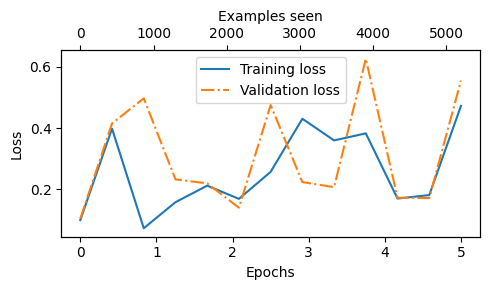

In [158]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

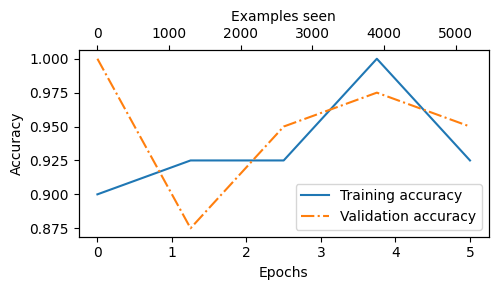

In [159]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [161]:
train_accuracy = calc_accuracy_loader(train_loader, gpt_openAI_model, device)
val_accuracy = calc_accuracy_loader(val_loader, gpt_openAI_model, device)
test_accuracy = calc_accuracy_loader(test_loader, gpt_openAI_model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 94.42%
Validation accuracy: 93.75%
Test accuracy: 93.92%


In [163]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [164]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, gpt_openAI_model, tokenizer, device, max_length=train_dataset.max_length
))

text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, gpt_openAI_model, tokenizer, device, max_length=train_dataset.max_length
))

spam
not spam


In [165]:
torch.save(gpt_openAI_model.state_dict(), "review_classifier_gpt_openAI_model.pth")

In [166]:
model_state_dict = torch.load("review_classifier_gpt_openAI_model.pth", map_location=device, weights_only=True)
gpt_openAI_model.load_state_dict(model_state_dict)

<All keys matched successfully>